In [1]:
import math

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from roboscout import *
from futil import *


In [2]:
s = scout(getData('matchlists/OchoaTot.csv')[:90])
t = scout(getData('matchlists/EdisonTot.csv')[:90])
contribs = s['contribution'].values()
contribs.extend(t['contribution'].values())
individual_outputs = sorted([item for sublist in contribs for item in sublist])

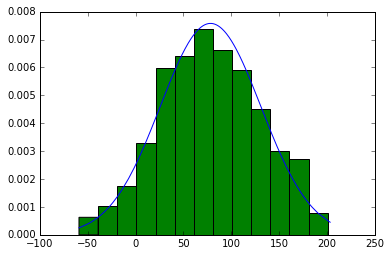

In [4]:
# for k, v in s['contribution'].iteritems():
#     a = sorted(v)
#     fit = stats.norm.pdf(a, np.mean(a), np.std(a))
#     plt.plot(a, fit, '-o')
bins = np.arange(min(individual_outputs), max(individual_outputs), 20)
fit = stats.norm.pdf(individual_outputs, np.mean(individual_outputs), np.std(individual_outputs))
plt.plot(individual_outputs,fit)
plt.hist(individual_outputs, bins, normed=True)
plt.show()

Below is a [Normal Probability Q-Q Plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). The distribution of the dataset (`individual_outputs`) on the Y-axis are compared against a randomly generated normal distribution on the X-axis. The closer the distributions match, the more linear the plot is. The red line represents a perfect normal distribution; it looks like the individual contribution distribution are pretty close to a normal distribution.

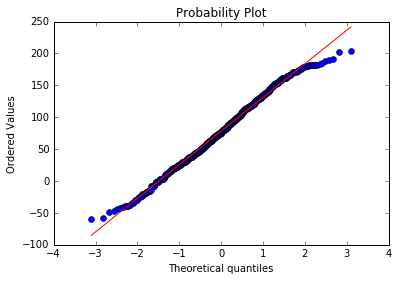

In [5]:
prob = stats.probplot(individual_outputs, plot=plt)
plt.show()

[Chi-Squared Distribution Test](https://www.khanacademy.org/math/statistics-probability/inference-categorical-data-chi-square-tests/chi-square-goodness-of-fit-tests/v/pearson-s-chi-square-test-goodness-of-fit): How likely is our observed contributions relative to our expected output?

In [6]:
Y = 16.92

data = map(lambda team: {'team': team, 'expo': s['expo'][team], 'scores': s['contribution'][team]}, s['expo'].keys())
data2 = map(lambda team: {'team': team, 'expo': t['expo'][team], 'scores': t['contribution'][team]}, t['expo'].keys())
data.extend(data2)
chis = []
for row in data:
    exp = row['expo']
    if exp == 0: continue
    d = map(lambda obs: pow(obs-exp, 2)/abs(exp), row['scores'])
    if row['team'] == '4200': continue
    X = sum(d) # chi-square statistic
    chis.append({'team': row['team'], 'chisquare': abs(X), 'dof': len(row['scores'])})

good = []
bad = []
# Xs = map(lambda c: c['chisquare'], chis)
# print avg(Xs)
for chi in chis:
    X = chi['chisquare']
    if X < Y: 
        good.append(chi['team'])
    else:
        bad.append(chi['team'])

print 'good data: %d – bad data: %d' % (len(good), len(bad))
print good
# pd.DataFrame(chis, columns=['team', 'chisquare', 'dof'])


good data: 29 – bad data: 98
['6929', '9872', '4029', '7152', '406', '10138', '11115', '8686', '4174', '4964', '11691', '9794', '5916', '6037', '11190', '8498', '4211', '8644', '8393', '7236', '3409', '12559', '10635', '5040', '10091', '8680', '11047', '519', '6079']


In [7]:
future_matches = [
    {'Red 1': '4174', 'Red 2': '8686', 'Blue 1': '4029', 'Blue 2': '7129'}
]

In [8]:
lists = ['matchlists/EdisonTot.csv', 'matchlists/OchoaTot.csv', 
         'matchlists/tesla1.csv', 'matchlists/hopper1.csv']


In [9]:
import match_simulation as sim
buckets = [[] for _ in xrange(11)]


for fpath in lists:
    matchlist = getData(fpath)
    rscout = scout(matchlist[:len(matchlist)*2/3])
    simulation = sim.simulate_matchlist(matchlist, rscout, len(matchlist)*2/3)
    
    results = [{
            'winner': 'Red' if r['Red Score'] > r['Blue Score'] else 'Blue',
            'probability': r['prediction'][0] if r['Red Score'] > r['Blue Score'] else r['prediction'][1],
            'other': r['prediction'][1] if r['Red Score'] > r['Blue Score'] else r['prediction'][0]
        } for r in simulation]
    for row in results:
        buckets[int(round(row['probability']/10))].append(1)
        buckets[int(round(row['other']/10))].append(0)

# pd.DataFrame(simulation, columns=['Round #', 'Red 1', 'Red 2', 'Blue 1', 'Blue 2', 'Red Score', 'Blue Score', 'prediction'])

In [11]:
calibration = [float(sum(l))/len(l) if len(l) > 0 else 0 for l in buckets]
w = [{'percent': '%d' % (int(x)*10), 'occurance': calibration[int(x)]*100} for x in xrange(len(calibration))]
pd.DataFrame(w, columns=['percent', 'occurance'])

# print buckets

,percent,occurance
0,0,47.887324
1,10,27.586207
2,20,59.259259
3,30,50.000000
4,40,30.000000
5,50,50.000000
6,60,70.000000
7,70,50.000000
8,80,40.740741
9,90,72.413793


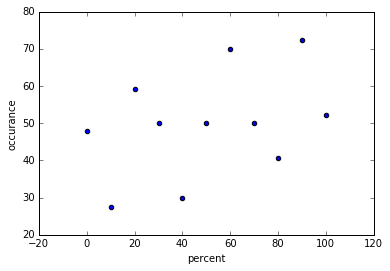

In [12]:
for row in w:
    plt.scatter(row['percent'], row['occurance'])
plt.ylabel('occurance')
plt.xlabel('percent')
plt.show()